## Imports

In [ ]:
!pip install datasets
!pip install scikit-learn transformers torch nltk
!pip install sentence_transformers
!pip install --upgrade tensorflow-datasets google-cloud-aiplatform google-cloud-bigquery tensorflow-metadata
!pip install numpy==1.24.4
!pip install nvidia-pyindex nvidia-tensorflow
!pip install tensorflow==2.12.0 transformers==4.26.0 protobuf==3.20.3

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.feature_extraction.text import CountVectorizer


import nltk
from nltk.corpus import stopwords

import re

import datasets
from datasets import load_dataset

import torch

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from gensim.models import KeyedVectors

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Data from HuggingFace

In [ ]:
datasets.logging.set_verbosity_error()

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Handmade_Products", trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Handmade_Products.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
df = dataset['full'].to_pandas()

In [ ]:
#dataset_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Handmade_Products", trust_remote_code=True)



## Uploading from Drive

In [ ]:
# Replace with the actual path in your Google Drive
file_path = '/content/drive/My Drive/Video_Games.jsonl'

# Read the JSONL file
df = pd.read_json(file_path, lines=True)

In [ ]:
# Replace with the actual path in your Google Drive
file_path_meta = '/content/drive/My Drive/meta_Video_Games.jsonl'

df_meta = pd.read_json(file_path_meta, lines=True)

## EDA & Preprocess

In [ ]:
# Merge the DataFrames on the parent_asin column
df_final = df[df['parent_asin'] == 'B0BZ4ZVMCL']

# Display the updated DataFrame
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 1686 to 663961
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             404 non-null    float64
 1   title              404 non-null    object 
 2   text               404 non-null    object 
 3   images             404 non-null    object 
 4   asin               404 non-null    object 
 5   parent_asin        404 non-null    object 
 6   user_id            404 non-null    object 
 7   timestamp          404 non-null    int64  
 8   helpful_vote       404 non-null    int64  
 9   verified_purchase  404 non-null    bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 32.0+ KB


In [ ]:
df_final = df_final.dropna()
# Check for null values in each column
null_counts = df_final.isnull().sum()
print(null_counts)


rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

df_final['cleaned_text'] = df_final['text'].apply(clean_text)
df_model = df_final[['cleaned_text', 'rating']]

In [ ]:
df_model.head(2)

,cleaned_text,rating
1686,look use son loves practical daily use decorat...,4.0
12628,anxious give stocking stuffer christmas please...,5.0


## SVM

In [ ]:
X = df_model['cleaned_text']
y = df_model['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_model['cleaned_text'])
y = df_model['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.25      0.25      0.25         4
         2.0       0.00      0.00      0.00         1
         3.0       1.00      0.17      0.29         6
         4.0       0.33      0.20      0.25         5
         5.0       0.89      0.97      0.93        65

    accuracy                           0.81        81
   macro avg       0.49      0.32      0.34        81
weighted avg       0.82      0.81      0.79        81



In [ ]:

coef = clf_svm.coef_.toarray()
feature_names = vectorizer.get_feature_names_out()


top_n = 20
sorted_indices = np.argsort(coef[0])[::-1]
top_features = [(feature_names[i], coef[0][i]) for i in sorted_indices[:top_n]]


print("Top palavras mais importantes no BoW:")
for word, weight in top_features:
    print(f"{word}: {weight:.4f}")

Top palavras mais importantes no BoW:
cheaply: 0.5078
made: 0.5022
beard: 0.4823
small: 0.4604
item: 0.3889
way: 0.3360
enough: 0.3198
returned: 0.3198
tiny: 0.3198
strong: 0.3198
looks: 0.3067
three: 0.3022
week: 0.3022
low: 0.3022
thing: 0.2597
itway: 0.2597
suggest: 0.2597
jokedont: 0.2597
quality: 0.1661
buying: 0.1628


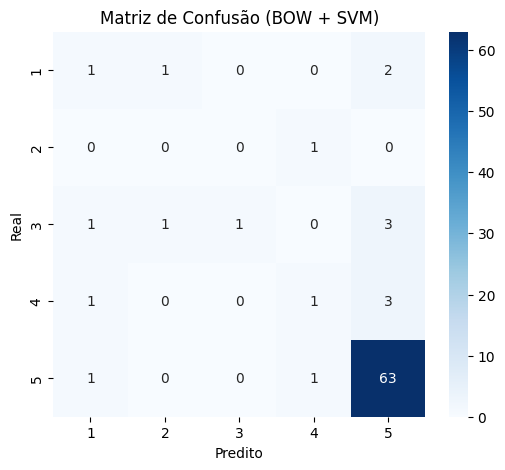

In [ ]:
conf_matrix_bow = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bow, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title('Matriz de Confusão (BOW + SVM)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

## SVM + Embeddings

In [ ]:
path = api.load("word2vec-google-news-300", return_path=True)
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def text_to_vector(text, embeddings, embedding_dim):
    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(word_vectors, axis=0)

df_finalEmbedding = df_model.copy()

df_finalEmbedding['vector'] = df_model['cleaned_text'].apply(lambda x: text_to_vector(x, word2vec_model, 300))

In [ ]:
X = np.vstack(df_finalEmbedding['vector'].values)
y = df_finalEmbedding['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:


model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))
print("R² Score:", r2_score(y_test, predictions))

MSE: 9099870788767.32
R² Score: -8570808533605.428


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_dim=300),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 1s 42ms/step - loss: 19.9678 - mae: 4.3289 - val_loss: 16.7579 - val_mae: 3.9678
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 14.6412 - mae: 3.6715 - val_loss: 10.7646 - val_mae: 3.1607
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 8.3364 - mae: 2.7246 - val_loss: 4.4198 - val_mae: 1.9820
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 2.8577 - mae: 1.4864 - val_loss: 1.5467 - val_mae: 0.9282
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 1.9177 - mae: 1.0558 - val_loss: 2.1547 - val_mae: 1.0427
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 2.0631 - mae: 1.0713 - val_loss: 1.4591 - val_mae: 0.8360
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 1.3268 - mae: 0.8960 - val_loss: 1.4093 - val_mae: 0.8935
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 1.4221 - mae: 0.9817 - val_lo

In [ ]:
y_pred = model.predict(X_test)

y_pred_classes = np.round(y_pred).astype(int)

y_pred_classes = np.clip(y_pred_classes, 1, 5)

print(classification_report(y_test, y_pred_classes))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00         1
         3.0       1.00      0.50      0.67         6
         4.0       0.12      0.80      0.21         5
         5.0       0.93      0.63      0.75        65

    accuracy                           0.59        81
   macro avg       0.41      0.39      0.33        81
weighted avg       0.83      0.59      0.67        81



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## BERT

In [ ]:
from transformers import BertTokenizer

# Baixar o tokenizador pré-treinado
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import TFRobertaForSequenceClassification

model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=6)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=2e-5)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

loss = SparseCategoricalCrossentropy(from_logits=True)
metrics = [SparseCategoricalAccuracy()]


In [ ]:
X = df_model['cleaned_text']
y = df_model['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
max_sent_length = 128  # Define o comprimento máximo das sentenças

def encode_sentence(sentence, tokenizer):
    encoded = tokenizer.encode_plus(
        sentence,
        max_length=max_sent_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'token_type_ids': encoded['token_type_ids']
    }

# Aplicar a codificação em um dataset (exemplo: lista de reviews)
encoded_data = [encode_sentence(s, tokenizer) for s in X_train]

In [ ]:

# Compilar o modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Preparar os inputs para o modelo
def prepare_inputs(encoded_data):
    input_ids = tf.concat([e['input_ids'] for e in encoded_data], axis=0)
    attention_mask = tf.concat([e['attention_mask'] for e in encoded_data], axis=0)
    token_type_ids = tf.concat([e['token_type_ids'] for e in encoded_data], axis=0)
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids
    }

train_inputs = prepare_inputs(encoded_data)
train_labels = tf.convert_to_tensor(y_train)

# Treinar o modelo
history = model.fit(
    train_inputs,
    train_labels,
    validation_split=0.1,
    batch_size=96,
    epochs=3
)


Epoch 1/3
3/3 [==============================] - 341s 96s/step - loss: 1.7003 - sparse_categorical_accuracy: 0.6443 - val_loss: 1.6078 - val_sparse_categorical_accuracy: 0.7241
Epoch 2/3
3/3 [==============================] - 299s 95s/step - loss: 1.4777 - sparse_categorical_accuracy: 0.7787 - val_loss: 1.1889 - val_sparse_categorical_accuracy: 0.7241
Epoch 3/3
3/3 [==============================] - 297s 94s/step - loss: 1.1228 - sparse_categorical_accuracy: 0.7787 - val_loss: 0.9982 - val_sparse_categorical_accuracy: 0.7241


In [ ]:
# Preparar os dados de teste
test_encoded = [encode_sentence(s, tokenizer) for s in X_test]
test_inputs = prepare_inputs(test_encoded)
test_labels = tf.convert_to_tensor(y_test)

# Fazer previsões
predictions = model.predict(test_inputs)


rating_to_label = {
    1: 'Very Bad',
    2: 'Bad',
    3: 'Neutral',
    4: 'Good',
    5: 'Excellent'
}

# Convert predicted_classes to a NumPy array or list
predicted_classes = tf.argmax(predictions.logits, axis=1).numpy()

# Map predictions to labels
predicted_labels = [rating_to_label[pred] for pred in predicted_classes]

# Assuming test_labels contain the actual labels
test_labels_mapped = [rating_to_label[int(label)] for label in test_labels.numpy()]

# Evaluate with metrics
from sklearn.metrics import classification_report
target_names = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Excellent']
print(classification_report(test_labels_mapped, predicted_labels, target_names=target_names))


# Assuming predictions are stored in `predicted_classes` (integer values from 1 to 5)
predicted_labels = [rating_to_label[pred] for pred in predicted_classes]

# Convert test_labels to a NumPy array or list
test_labels_numpy = test_labels.numpy() if tf.is_tensor(test_labels) else test_labels

# Map test_labels to their string representations
test_labels_mapped = [rating_to_label[int(label)] for label in test_labels_numpy]

# Evaluate with metrics
from sklearn.metrics import classification_report
target_names = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Excellent']
print(classification_report(test_labels_mapped, predicted_labels, target_names=target_names))



4/4 [==============================] - 43s 11s/step
              precision    recall  f1-score   support

    Very Bad       0.00      0.00      0.00         5
         Bad       0.79      1.00      0.88        96
     Neutral       0.00      0.00      0.00         8
        Good       0.00      0.00      0.00         7
   Excellent       0.00      0.00      0.00         6

    accuracy                           0.79       122
   macro avg       0.16      0.20      0.18       122
weighted avg       0.62      0.79      0.69       122

              precision    recall  f1-score   support

    Very Bad       0.00      0.00      0.00         5
         Bad       0.79      1.00      0.88        96
     Neutral       0.00      0.00      0.00         8
        Good       0.00      0.00      0.00         7
   Excellent       0.00      0.00      0.00         6

    accuracy                           0.79       122
   macro avg       0.16      0.20      0.18       122
weighted avg       0.62  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Ensure both test_labels and predicted_classes are NumPy arrays
test_labels_numpy = test_labels.numpy() if tf.is_tensor(test_labels) else np.array(test_labels)
predicted_classes_numpy = predicted_classes.numpy() if tf.is_tensor(predicted_classes) else np.array(predicted_classes)

# Compute metrics
accuracy = accuracy_score(test_labels_numpy, predicted_classes_numpy)
f1 = f1_score(test_labels_numpy, predicted_classes_numpy, average='weighted')

# Display results
import pandas as pd
results = pd.DataFrame({
    'Métrica': ['Acurácia', 'F1-Score'],
    'Valor': [accuracy, f1]
})
print(results)


    Métrica     Valor
0  Acurácia  0.786885
1  F1-Score  0.693037


# SVM + EMBEDDINGS

In [ ]:
from transformers import BertModel
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_batch_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    # Take the mean over the sequence dimension for embeddings
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Split your DataFrame into batches
batch_size = 96  # Adjust batch size based on your hardware
text_batches = [df['text'][i:i+batch_size] for i in range(0, len(df), batch_size)]

# Generate embeddings in batches
embeddings = []
for batch in text_batches:
    embeddings.extend(get_batch_embeddings(batch.tolist()))

# Add embeddings back to the DataFrame
df['embeddings'] = embeddings

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Convert embeddings to feature matrix
X = np.stack(df['embeddings'].values)
y = df['ratings']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Predict ratings
y_pred = svm.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
